In [398]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
plt.style.use('ggplot')
from warnings import filterwarnings

pd.set_option('display.float_format', lambda num:'%1.3f'%num)
pd.set_option('display.max_columns', 99)
filterwarnings('ignore')

# Data Description

Feature | Description
:---|:---
app_id |The unique application id.
category | The category under which app is categorized on the store.
reviews| The number of reviews received on the store.
size| Size of the app available for download (in KB/MB)
installs| The number of people who had installed this app atleast once.
price| The price of the app (in US $)
suitable_for| Rating given to app based on the usage and content.
last_update| When was the app updated last time by the developers.
latest_ver| The latest version of the app available for download.
popularity| User popularity (High/Low)

# Data Wrangling & Visualization 




In [399]:
data = pd.read_csv("train.csv")

In [400]:
data.head()

,app_id,category,reviews,size,installs,price,suitable_for,last_update,latest_ver,popularity
0,330090,PERSONALIZATION,4,511k,50+,0,Everyone,"December 31, 2016",1.4,High
1,226147,GAME,568391,5.2M,"5,000,000+",0,Teen,"July 1, 2014",4.3.1,High
2,107000,FAMILY,144,70M,"1,000+",$2.99,Teen,"January 26, 2018",1.0.0,High
3,217582,FAMILY,1499466,96M,"10,000,000+",0,Teen,"July 24, 2018",1.25.0,High
4,370113,DATING,84,4.5M,"1,000+",0,Mature 17+,"July 6, 2018",8.2,High


In [401]:
#Explore columns
data.columns

Index(['app_id', 'category', 'reviews', 'size', 'installs', 'price',
       'suitable_for', 'last_update', 'latest_ver', 'popularity'],
      dtype='object')

In [402]:
#Description
data.describe()

,app_id,reviews
count,1975.000,1975.000
mean,490685.787,198816.163
std,288098.937,1494090.662
min,1160.000,1.000
25%,239249.500,33.000
50%,481867.000,516.000
75%,737373.500,19122.000
max,999218.000,44891723.000


# Visualization, Modeling, Machine Learning

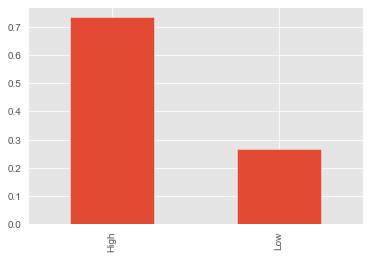

In [404]:
data['popularity'].value_counts(normalize=True).plot(kind='bar')
plt.show()

So our data is skewed. We have around 30% of low popular apps.

In [405]:
popularity_label={'High':1,'Low':0}
data['popularity']=data['popularity'].map(popularity_label)

In [406]:
data['category'].unique()

array(['PERSONALIZATION', 'GAME', 'FAMILY', 'DATING', 'PARENTING',
       'PHOTOGRAPHY', 'TOOLS', 'MEDICAL', 'SOCIAL', 'BOOKS_AND_REFERENCE',
       'FOOD_AND_DRINK', 'AUTO_AND_VEHICLES', 'FINANCE',
       'HEALTH_AND_FITNESS', 'SHOPPING', 'LIFESTYLE', 'EDUCATION',
       'SPORTS', 'NEWS_AND_MAGAZINES', 'COMMUNICATION', 'BUSINESS',
       'PRODUCTIVITY', 'VIDEO_PLAYERS', 'BEAUTY', 'TRAVEL_AND_LOCAL',
       'WEATHER', 'MAPS_AND_NAVIGATION', 'ART_AND_DESIGN', 'EVENTS',
       'COMICS', 'HOUSE_AND_HOME', 'ENTERTAINMENT', 'LIBRARIES_AND_DEMO'],
      dtype=object)

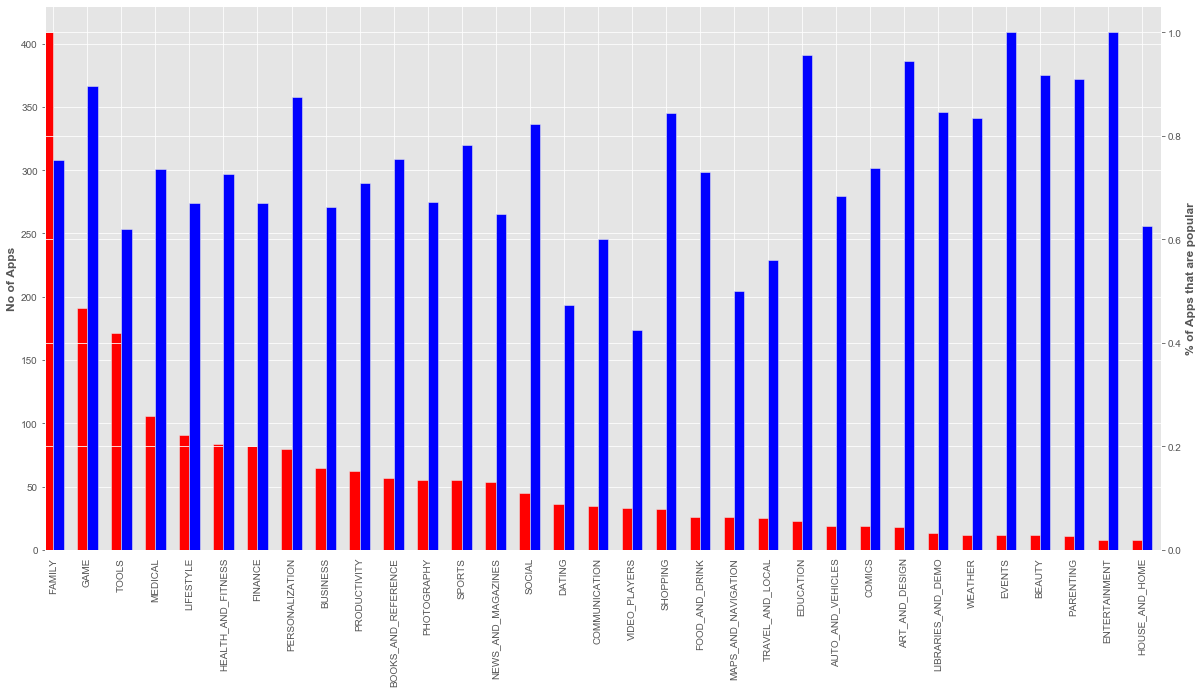

In [407]:
plot_data=data.groupby('category').agg(
        {
            'popularity':['count','mean']
        }).sort_values(by=('popularity','count'),ascending=False).reset_index()
fig = plt.figure(figsize=(20,10)) 
ax = fig.add_subplot(111) 
ax2 = ax.twinx()
width = 0.3
plot_data[('popularity','count')].plot(kind='bar', color='red', ax=ax, width=width, position=1)
plot_data[('popularity','mean')].plot(kind='bar', color='blue', ax=ax2, width=width, position=0)

ax.set_ylabel('No of Apps',fontweight='bold')
ax2.set_ylabel('% of Apps that are popular',fontweight='bold')

plt.xticks(np.arange(len(plot_data)),plot_data['category'])
plt.show()

In [408]:
data['price']=data['price'].str.replace('$','').astype(float)
print ('1. Free apps are ' + str(sum(data.price == 0)))
print ('2. Counting (outliers) super expensive apps ' + str(sum(data.price > 50)))
print (' -  which is around ' + str(sum(data.price > 50)/len(data.price)*100) +
       " % of the total Apps")
print (' Thus we will dropping the following apps')
outlier=data[data.price>50][['app_id','price','category','popularity']]
outlier

1. Free apps are 1780
2. Counting (outliers) super expensive apps 3
 -  which is around 0.1518987341772152 % of the total Apps
 Thus we will dropping the following apps


,app_id,price,category,popularity
40,368255,379.990,LIFESTYLE,0
66,701156,79.990,MEDICAL,1
814,505673,399.990,FINANCE,0


In [409]:
# removing
paidapps =data[((data.price<50) & (data.price>=0))]
print('Now the max price of any app in new data is : ' + str(max(paidapps.price)))
print('Now the min price of any app in new data is : ' + str(min(paidapps.price)))
data=paidapps

Now the max price of any app in new data is : 33.99
Now the min price of any app in new data is : 0.0


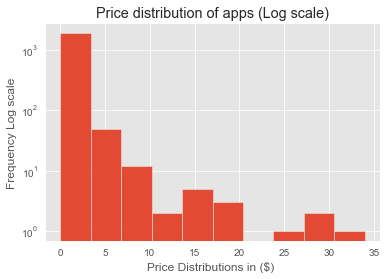

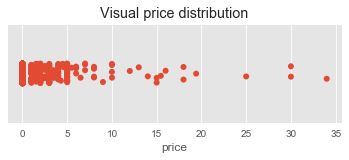

In [410]:
plt.hist(data.price,log=True)
plt.title('Price distribution of apps (Log scale)')
plt.ylabel("Frequency Log scale")
plt.xlabel("Price Distributions in ($) ")
plt.show()

plt.subplot(2,1,2)
plt.title('Visual price distribution')
sns.stripplot(data=data,y='price',jitter= True,orient = 'h' ,size=6)
plt.show()

Count of paid apps is exponentially decreasing as the price increases.  
Very few apps have been priced above 20.So its important to keep price of your app below 20$.

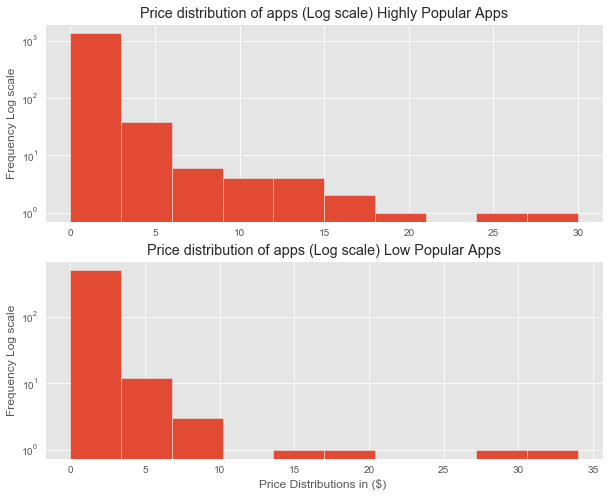

In [411]:
fig = plt.figure(figsize=(10,8))

plt.subplot(2,1,1)
plt.hist(data[data['popularity']==1].price,log=True)
plt.title('Price distribution of apps (Log scale) Highly Popular Apps')
plt.ylabel("Frequency Log scale")

plt.subplot(2,1,2)
plt.hist(data[data['popularity']==0].price,log=True)
plt.title('Price distribution of apps (Log scale) Low Popular Apps')
plt.ylabel("Frequency Log scale")
plt.xlabel("Price Distributions in ($) ")

plt.show()

In [412]:
# reducing the number of categories
s = data.category.value_counts().index[:4]
def categ(x):
    if x in s:
        return x
    else : 
        return "Others"

data['broad_genre']= data.category.apply(lambda x : categ(x))

In [413]:
free = data[data.price<=1].broad_genre.value_counts().sort_index().to_frame()
paid = data[data.price>0].broad_genre.value_counts().sort_index().to_frame()
total = data.broad_genre.value_counts().sort_index().to_frame()
free.columns=['free']
paid.columns=['paid']
total.columns=['total']
dist = free.join(paid).join(total)
dist ['paid_per'] = dist.paid*100/dist.total
dist ['free_per'] = dist.free*100/dist.total
dist

,free,paid,total,paid_per,free_per
FAMILY,363,51,409,12.469,88.753
GAME,171,25,191,13.089,89.529
MEDICAL,84,23,105,21.905,80.000
Others,1043,72,1096,6.569,95.164
TOOLS,154,21,171,12.281,90.058


<Figure size 1080x576 with 0 Axes>

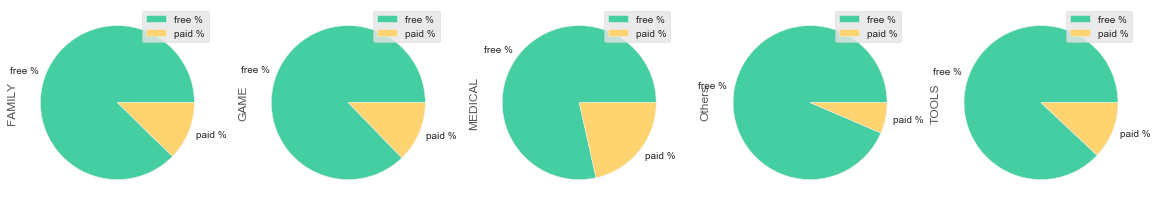

In [414]:
# for pie chart
pies = dist[['free_per','paid_per']]
pies.columns=['free %','paid %']
plt.figure(figsize=(15,8))
pies.T.plot.pie(subplots=True,figsize=(20,4),colors=['#45cea2','#fdd470'])
plt.show()

Family & Game have the highest number of paid apps.

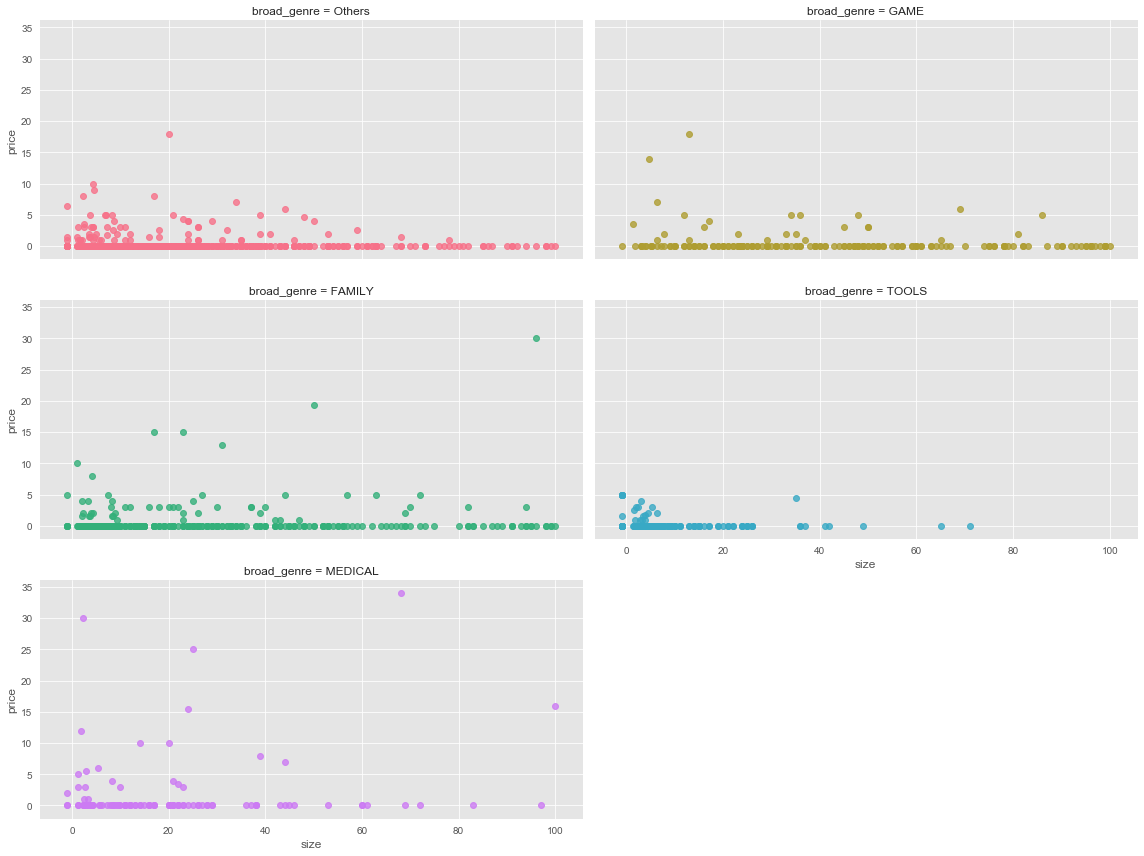

In [415]:
def size_clean_func(x):
    if x[-1]=='M':
        return float(x[:-1])
    elif x[-1]=='K':
        return float(x[:-1])/1024
    else:
        return -1
size_clean=data[data['size']!='Varies with device']
size_clean['size']=size_clean['size'].apply(lambda x:size_clean_func(x))


sns.color_palette("husl", 8)
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.lmplot(data=size_clean,
           x='size',y='price',size=4, aspect=2,col_wrap=2,hue='broad_genre',
           col='broad_genre',fit_reg=False,palette = sns.color_palette("husl", 5))
plt.show()

We can see that Size of the app doesn't correspond to increase in price as well.

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

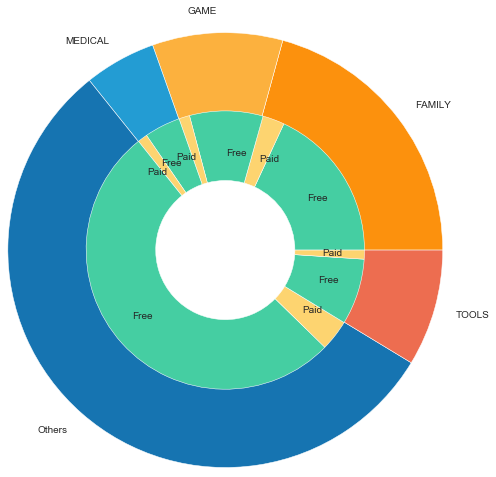

In [416]:
plt.figure(figsize=(10,10))
f=pd.DataFrame(index=np.arange(0,10,2),data=dist.free.values,columns=['num'])
p=pd.DataFrame(index=np.arange(1,11,2),data=dist.paid.values,columns=['num'])
final = pd.concat([f,p],names=['labels']).sort_index()
final.num.tolist()

plt.figure(figsize=(20,20))
group_names=data.broad_genre.value_counts().sort_index().index
group_size=data.broad_genre.value_counts().sort_index().tolist()
h = ['Free', 'Paid']
subgroup_names= 5*h
sub= ['#45cea2','#fdd470']
subcolors= 5*sub
subgroup_size=final.num.tolist()


# First Ring (outside)
fig, ax = plt.subplots()
ax.axis('equal')
mypie, _ = ax.pie(group_size, radius=2.5, labels=group_names, colors=BlueOrangeWapang)
plt.setp( mypie, width=1.2, edgecolor='white')

# Second Ring (Inside)
mypie2, _ = ax.pie(subgroup_size, radius=1.6, labels=subgroup_names, labeldistance=0.7, colors=subcolors)
plt.setp( mypie2, width=0.8, edgecolor='white')
plt.margins(0,0)

plt.show()

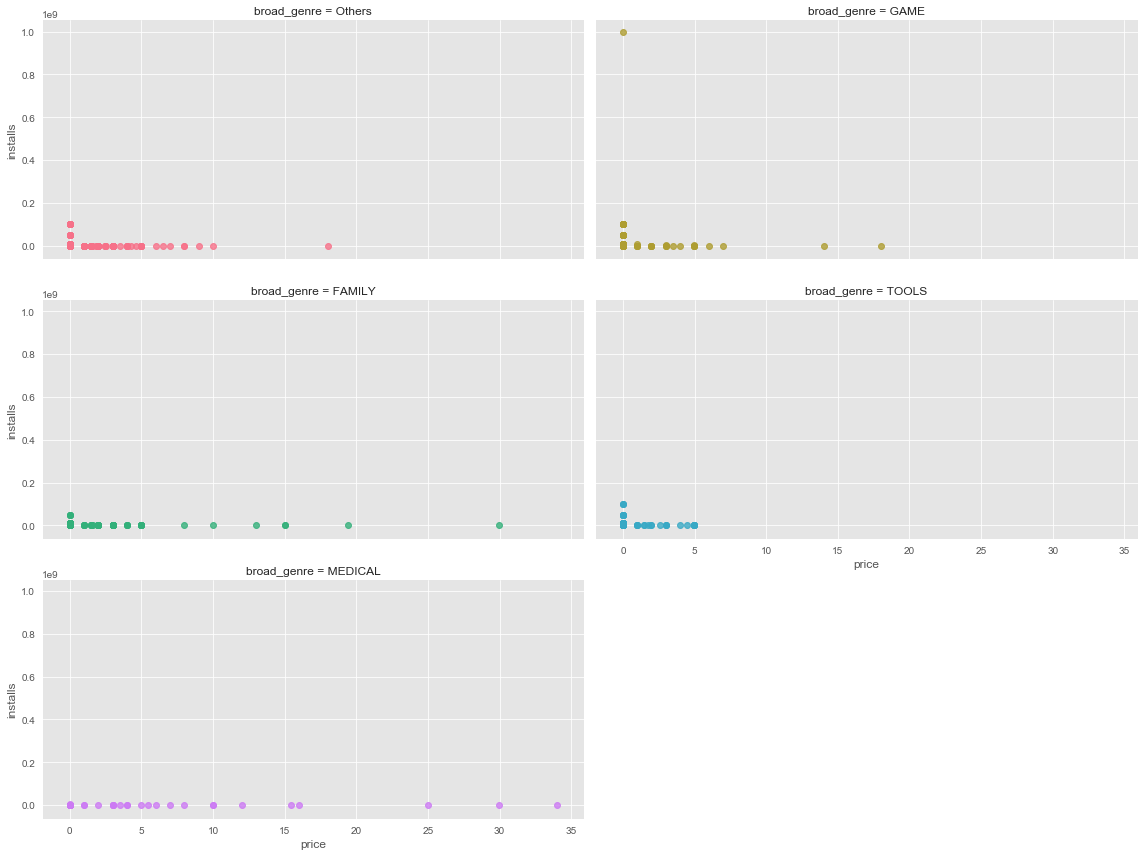

In [417]:
'''
How installs vary as the app size increases
'''
data['installs']=data['installs'].str.replace(',','').str.replace('+','').astype(int)
sns.color_palette("husl", 8)
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.lmplot(data=data,
           x='price',y='installs',size=4, aspect=2,col_wrap=2,hue='broad_genre',
           col='broad_genre',fit_reg=False,palette = sns.color_palette("husl", 5))
plt.show()

In [504]:
data = pd.read_csv("train.csv")
data['size']=data['size'].apply(lambda x:size_clean_func(x))
data['installs']=data['installs'].str.replace(',','').str.replace('+','').astype(int)
data['popularity']=data['popularity'].map(popularity_label)
data['price']=data['price'].str.replace('$','').astype(float)
data=pd.get_dummies(data,columns=['category','suitable_for'])
data['last_update_month']=pd.to_datetime(data['last_update']).dt.month
data['last_update_year']=pd.to_datetime(data['last_update']).dt.year
data['latest_ver'].fillna('0.0',inplace=True)
data['major_version']=data['latest_ver'].str.split('.').str[0].astype(int)
del data['last_update'],data['latest_ver'],data['app_id']
data.loc[data['size']=='Varies with device','size']=data['size'].median()
data.loc[data['price']=='Varies with device','price']=0
data['reviews']=np.log(1+data['reviews'])
data['installs']=np.log(1+data['installs'])
data.head()

,reviews,size,installs,price,popularity,category_ART_AND_DESIGN,category_AUTO_AND_VEHICLES,category_BEAUTY,category_BOOKS_AND_REFERENCE,category_BUSINESS,category_COMICS,category_COMMUNICATION,category_DATING,category_EDUCATION,category_ENTERTAINMENT,category_EVENTS,category_FAMILY,category_FINANCE,category_FOOD_AND_DRINK,category_GAME,category_HEALTH_AND_FITNESS,category_HOUSE_AND_HOME,category_LIBRARIES_AND_DEMO,category_LIFESTYLE,category_MAPS_AND_NAVIGATION,category_MEDICAL,category_NEWS_AND_MAGAZINES,category_PARENTING,category_PERSONALIZATION,category_PHOTOGRAPHY,category_PRODUCTIVITY,category_SHOPPING,category_SOCIAL,category_SPORTS,category_TOOLS,category_TRAVEL_AND_LOCAL,category_VIDEO_PLAYERS,category_WEATHER,suitable_for_Adults only 18+,suitable_for_Everyone,suitable_for_Everyone 10+,suitable_for_Mature 17+,suitable_for_Teen,last_update_month,last_update_year,major_version
0,1.609,-1.000,3.932,0.000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,12,2016,1
1,13.251,5.200,15.425,0.000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,7,2014,4
2,4.977,70.000,6.909,2.990,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2018,1
3,14.221,96.000,16.118,0.000,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,7,2018,1
4,4.443,4.500,6.909,0.000,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,7,2018,8


In [505]:
X_train,X_valid,Y_train,Y_valid=train_test_split(
    data.drop(['popularity'], axis = 1),
    data[['popularity']],
    train_size=0.8)

In [506]:
'''
Model-I: Logistic Regression for binary classification
'''
clf = RandomForestClassifier().fit(X_train, Y_train)
Y_pred = clf.predict(X_valid)
accuracy_score(Y_valid,Y_pred)

0.7063291139240506

In [507]:
'''
Model-II: Using Xgboost for classification.
'''
model = XGBClassifier()
model.fit(X_train, Y_train) 

Y_pred=model.predict(X_valid)
accuracy_score(Y_valid,Y_pred)

0.769620253164557

In [538]:
'''
Hyperparameter tuning using Xgboost
'''
params = {
        'min_child_weight': [1, 3,5, 10],
        'gamma': [0.2,0.5, 1, 1.5, 2, 5],
        'subsample': [0.2,0.4,0.6, 0.8, 1.0],
        'colsample_bytree': [0.4,0.6, 0.8, 1.0],
        'max_depth': [4, 3, 5,2]
        }

xgb = XGBClassifier(n_estimators=100, objective='binary:logistic',
                    silent=True, nthread=1)

random_search = RandomizedSearchCV(xgb, 
                                   param_distributions=params,
                                   n_iter=5, 
                                   scoring='accuracy', 
                                   n_jobs=-1,
                                cv=5)
random_search.fit(X_train, Y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=1,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           re...
                                           seed=None, silent=True, subsample=1,
                                           verbosity=1),
                   iid='warn', n_iter=5, 

In [539]:
'''
Selecting the best model and calculating the accuracy of the classifier.
'''
best_model=random_search.best_estimator_
Y_pred=best_model.predict(X_valid)
accuracy_score(Y_valid,Y_pred)

0.7417721518987341

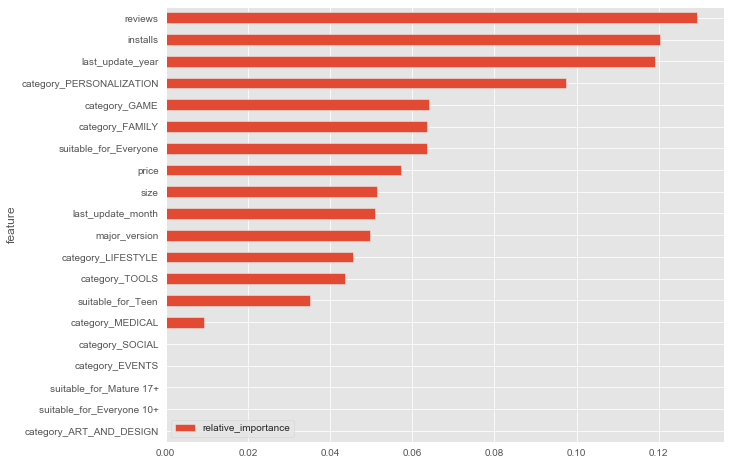

In [540]:
'''
Feature Importance
'''
feature_imp=pd.DataFrame()
for feature,imp in zip(X_train.columns,best_model.feature_importances_):
    temp=pd.DataFrame([feature,imp]).T
    feature_imp=feature_imp.append(temp)
feature_imp.columns=['feature','relative_importance']
feature_imp.sort_values(by='relative_importance',inplace=True)
feature_imp.set_index('feature',inplace=True)
feature_imp.iloc[-20:,:].plot(kind='barh',figsize=(10,8))
plt.show()

In [547]:
imp_features=feature_imp[feature_imp['relative_importance']>0.04].index.tolist()

In [548]:
model.fit(data[imp_features],data['popularity'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

# PREDICTION ON THE TEST SET

In [549]:
test_data = pd.read_csv("test.csv")
test_data['size']=test_data['size'].apply(lambda x:size_clean_func(x))
test_data['installs']=test_data['installs'].str.replace(',','').str.replace('+','').astype(int)
test_data['price']=test_data['price'].str.replace('$','').astype(float)
test_data=pd.get_dummies(test_data,columns=['category','suitable_for'])
test_data['last_update_month']=pd.to_datetime(test_data['last_update']).dt.month
test_data['last_update_year']=pd.to_datetime(test_data['last_update']).dt.year
test_data['latest_ver'].fillna('0.0',inplace=True)
test_data['major_version']=test_data['latest_ver'].str.split('.').str[0].astype(int)
del test_data['last_update'],test_data['latest_ver'],test_data['app_id']


test_data['reviews']=np.log(1+test_data['reviews'])
test_data['installs']=np.log(1+test_data['installs'])


prediction=model.predict(test_data[imp_features])

In [550]:
test_data = pd.read_csv("test.csv")
prediction_df=pd.DataFrame(
    {
        'app_id':test_data.app_id,
        'popularity':prediction
    }
)

In [551]:
prediction_df['popularity']=prediction_df['popularity'].map({1:'High',0:'Low'})

In [552]:
prediction_df.to_csv('prediction.csv',index=False)